In [16]:
from dotenv import load_dotenv

load_dotenv()

True

### Nodes & Edges

In [17]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from langgraph.graph import END, MessageGraph

model = ChatOpenAI(temperature=0)

def add_one(input: list[HumanMessage]):
    input[0].content = input[0].content + "a"
    return input


graph = MessageGraph()

graph.add_node("branch_a", add_one)
graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_a", "branch_c")

graph.add_node("branch_b", add_one)
graph.add_node("branch_c", add_one)

graph.add_edge("branch_b", "final_node")
graph.add_edge("branch_c", "final_node")

graph.add_node("final_node", add_one)
graph.add_edge("final_node", "end_code")

graph.add_node("end_code", add_one)
graph.add_edge("end_code", END)

graph.set_entry_point("branch_a")

runnable = graph.compile()


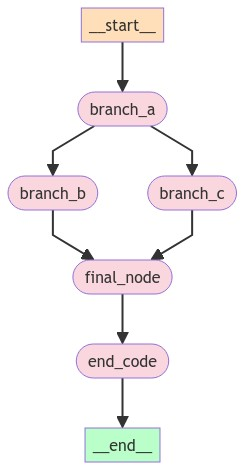

In [18]:
from IPython.display import Image, display

display(Image(runnable.get_graph().draw_mermaid_png()))

In [19]:
runnable.invoke("a")

[HumanMessage(content='aaaaaa', id='b71c7668-473f-4afc-b64d-851ebddb6e99')]

### Conditional Edges

In [20]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from langgraph.graph import END, MessageGraph

model = ChatOpenAI(temperature=0)


def entry(input: list[HumanMessage]):
    return input

def work_with_b(input: list[HumanMessage]):
    print("Using branch B")
    return "b"

def work_with_c(input: list[HumanMessage]):
    print("Using branch C")
    return "c"

def router(input: list[HumanMessage]):
    if "use_b" in input[0].content:
        return "branch_b"
    else:
        return "branch_c"

graph = MessageGraph()

graph.add_node("branch_a", entry)
graph.add_node("branch_b", work_with_b)
graph.add_node("branch_c", work_with_c)

graph.add_conditional_edges(
    "branch_a",
    router,
    {"branch_b": "branch_b", "branch_c": "branch_c"}
)
graph.add_edge("branch_b", END)
graph.add_edge("branch_c", END)

graph.set_entry_point("branch_a")

runnable = graph.compile()

In [21]:
runnable = graph.compile()

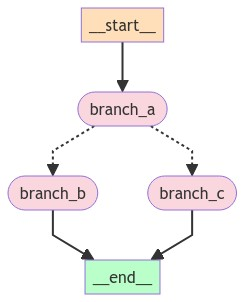

In [22]:
display(Image(runnable.get_graph().draw_mermaid_png()))

In [23]:
runnable.invoke("hello")

Using branch C


[HumanMessage(content='hello', id='c0caf2af-3dd2-49a1-903b-5c2cbdbd00ad'),
 HumanMessage(content='c', id='a49c98f5-c2ec-4e41-b9b0-3011e9c8d9c0')]

In [24]:
runnable.invoke("I want to use_b")

Using branch B


[HumanMessage(content='I want to use_b', id='1cdfa60d-f8c4-4a97-b950-72d6ad83ae91'),
 HumanMessage(content='b', id='31b5aad0-bb9a-40b9-9528-f5f4c540f3aa')]

### Cycles

In [25]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from langgraph.graph import END, MessageGraph

model = ChatOpenAI(temperature=0)

def entry(input: list[HumanMessage]):
    print("Agent processing:", input[-1].content)
    if "end" in input[-1].content:
        return ["end"]
    return ["continue"]

def action(input: list[HumanMessage]):
    print("Action taken:", [msg.content for msg in input])
    if len(input) > 5:
        input.append(HumanMessage(content="end"))
    else:
        input.append(HumanMessage(content="continue"))
    return input

def should_continue(input: list):
    last_message = input[-1]
    if "end" in last_message.content:
        return "__end__"
    return "action"


graph = MessageGraph()

graph.add_node("agent", entry)
graph.add_node("action", action)

graph.add_conditional_edges(
    "agent",
    should_continue,
    {"action": "action", "__end__": END}
)
graph.add_edge("action", "agent")

graph.set_entry_point("agent")

runnable = graph.compile()


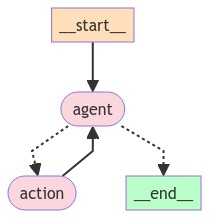

In [26]:
display(Image(runnable.get_graph().draw_mermaid_png()))

In [27]:
runnable.invoke("Hello")

Agent processing: Hello
Action taken: ['Hello', 'continue']
Agent processing: continue
Action taken: ['Hello', 'continue', 'continue', 'continue']
Agent processing: continue
Action taken: ['Hello', 'continue', 'continue', 'continue', 'continue', 'continue']
Agent processing: end


[HumanMessage(content='Hello', id='1cd4c69c-6dda-41c7-89d9-09dcf22a5f4d'),
 HumanMessage(content='continue', id='3f09592f-f74c-43d4-a7bf-30a5bd18a202'),
 HumanMessage(content='continue', id='0fa58276-bcea-45f6-acf8-c7554d6a2395'),
 HumanMessage(content='continue', id='d009a589-55a1-471d-ae4a-65ba273bff45'),
 HumanMessage(content='continue', id='39e69e31-dd27-468e-a5b4-6292e1163109'),
 HumanMessage(content='continue', id='c2c4f28d-c174-41f7-ad36-e79e14cc0d6f'),
 HumanMessage(content='end', id='6c0d1e45-ed6d-460e-a604-df22b2d453fc'),
 HumanMessage(content='end', id='9bde7746-5e22-4724-a8bc-e205fabac2ab')]

### AgentState

In [40]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Literal

class AgentState(TypedDict):
    article_state: str

def get_transfer_news_grade(state: AgentState) -> AgentState:
    print("State in get_transfer_news_grade:", state)
    return state

def process_article(state: AgentState) -> AgentState:
    print("State in process_article:", state)
    return state

def translate_article(state: AgentState) -> AgentState:
    print("State in translate_article:", state)
    # Modify the article_state to reflect translation
    state["article_state"] = "Translated: " + state["article_state"]
    return state

def expand_article(state: AgentState) -> AgentState:
    print("State in expand_article:", state)
    # Modify the article_state to reflect expansion
    state["article_state"] = state["article_state"] + " (Expanded)"
    return state

def publisher(state: AgentState) -> AgentState:
    print("FINAL_STATE in publisher:", state)
    return state

def evaluator_router(state: AgentState) -> Literal["news_chef", "not_relevant"]:
    if "Messi" in state["article_state"]:
        return "news_chef"
    else:
        return "not_relevant"

def news_chef_router(state: AgentState) -> Literal["translator", "publisher", "expander"]:
    # Logic to determine next step
    if "expand" in state["article_state"]:
        return "expander"
    elif "translate" in state["article_state"]:
        return "translator"
    else:
        return "publisher"

def translator_router(state: AgentState) -> Literal["news_chef"]:
    return "news_chef"

def expander_router(state: AgentState) -> Literal["news_chef"]:
    return "news_chef"

workflow = StateGraph(AgentState)

workflow.add_node("evaluator", get_transfer_news_grade)
workflow.add_node("news_chef", process_article)
workflow.add_node("translator", translate_article)
workflow.add_node("expander", expand_article)
workflow.add_node("publisher", publisher)

workflow.set_entry_point("evaluator")

workflow.add_conditional_edges(
    "evaluator",
    evaluator_router,
    {"news_chef": "news_chef", "not_relevant": END}
)

workflow.add_conditional_edges(
    "news_chef",
    news_chef_router,
    {"translator": "translator", "publisher": "publisher", "expander": "expander"}
)

workflow.add_conditional_edges(
    "translator",
    translator_router,
    {"news_chef": "news_chef"}
)

workflow.add_conditional_edges(
    "expander",
    expander_router,
    {"news_chef": "news_chef"}
)

workflow.add_edge("publisher", END)

app = workflow.compile()

# Initial state for the workflow
initial_state = {"article_state": "Messi gonna switch from barca to real madrid"}
result = app.invoke(initial_state)

# Print the final result
print("Final result:", result)


State in get_transfer_news_grade: {'article_state': 'Messi gonna switch from barca to real madrid'}
State in process_article: {'article_state': 'Messi gonna switch from barca to real madrid'}
FINAL_STATE in publisher: {'article_state': 'Messi gonna switch from barca to real madrid'}
Final result: {'article_state': 'Messi gonna switch from barca to real madrid'}


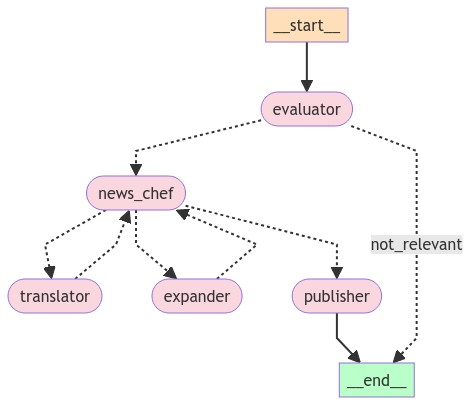

In [41]:
display(Image(app.get_graph().draw_mermaid_png()))

In [35]:
initial_state = {"message": "hello world", "iteration": 1}
result = app.invoke(initial_state)

print(result)

to_uppercase: {'message': 'HELLO WORLD', 'iteration': 2}
remove_vowels: {'message': 'HLL WRLD', 'iteration': 3}
{'message': 'HLL WRLD', 'iteration': 3}


### Real Agent - now lets create an Agent that actually does something

In [ ]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(temperature=0)

In [ ]:
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    api_call_count: int = 0

In [ ]:
from langchain_core.tools import tool
import random

@tool
def fake_weather_api(city: str) -> str:
    """Check the weather in a specified city. The API is available randomly, approximately every third call."""

    if random.randint(1, 3) == 1:  # Approximately one-third chance
        return "Sunny, 22°C"
    else:
        return "Service temporarily unavailable"

In [ ]:
print(fake_weather_api("New York"))
print(fake_weather_api("London"))
print(fake_weather_api("Berlin"))

In [ ]:
llm_with_tools = model.bind_tools([fake_weather_api])

In [ ]:
from langchain_core.messages import HumanMessage, ToolMessage

tool_mapping = {"fake_weather_api": fake_weather_api}

messages = [HumanMessage("How will the weather be in munich today? I would like to eat outside if possible")]
llm_output = llm_with_tools.invoke(messages)
messages.append(llm_output)
print(messages)

In [ ]:
for tool_call in llm_output.tool_calls:
    tool = tool_mapping[tool_call["name"].lower()]
    tool_output = tool.invoke(tool_call["args"])
    messages.append(ToolMessage(content=tool_output, tool_call_id=tool_call["id"]))

llm_with_tools.invoke(messages)

In [ ]:
def should_continue(state: AgentState):
    print("STATE:", state)
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return "end"
    else:
        return "continue"

def call_model(state: AgentState):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response], "api_call_count": state["api_call_count"]}

def call_tool(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    tool_call = last_message.tool_calls[0]
    tool = tool_mapping[tool_call["name"].lower()]
    tool_output = tool.invoke(tool_call["args"])
    state['api_call_count'] += 1
    print("Tool output:", tool_output)
    print("API call count after this tool call:", state['api_call_count'])
    tool_message = ToolMessage(content=tool_output, tool_call_id=tool_call["id"])
    return {"messages": [tool_message], "api_call_count": state["api_call_count"]}


In [ ]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentState)

workflow.add_node("agent", call_model)
workflow.add_node("action", call_tool)

workflow.set_entry_point("agent")

workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "action",
        "end": END,
    },
)
workflow.add_edge("action", "agent")
workflow.set_entry_point("agent")

app = workflow.compile()

In [ ]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

In [ ]:
from langchain_core.messages import SystemMessage

system_message =  SystemMessage(content="You are responsible for answering user questions. You use tools for that, These tools sometimes fail and you are very resilient and trying them again")
human_message = HumanMessage(content="How is the weather in munich today?")
messages = [system_message, human_message]

result = app.invoke({"messages": messages, "api_call_count": 0})

In [ ]:
print(result["messages"][-1].content)
print(result["api_call_count"])